In [1]:
# standard imports
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# own imports
import sys
sys.path.append("../../ml-library/")

from models import VariationalAutoencoder
from layers import GaussianSample
from utils import bce_loss

In [3]:
# set device
if torch.cuda.is_available():
    device = "cuda:0"
    torch.cuda.empty_cache()
else: 
    device = "cpu"

print(f"Using device {device}")

Using device cuda:0


In [6]:
# get data
from data import get_mnist
train, test = get_mnist(batch_size=64)

# Model Definition

In [4]:
# Model Parameters
x_dim   = 784
z_dim   = 64
h_dims  = [512, 256, 128]

In [5]:
# Define model (and port to device)
model = VariationalAutoencoder([x_dim, z_dim, h_dims])
model.to(device)
print(model)

VariationalAutoencoder(
  (encoder): Encoder(
    (hidden): ModuleList(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=128, bias=True)
    )
    (sample): GaussianSample(
      (mu): Linear(in_features=128, out_features=64, bias=True)
      (log_var): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (decoder): Decoder(
    (hidden): ModuleList(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=512, bias=True)
    )
    (reconstruction): Linear(in_features=512, out_features=784, bias=True)
    (activation): Sigmoid()
  )
)


# Training

Uses functionality from /data/gen_mnist.py

In [7]:
# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))

In [28]:
from torch.autograd import Variable

# 
epochs = 10
l_elbo = np.zeros(epochs)
l_kld = np.zeros(epochs)
l_recon = np.zeros(epochs)

# Training Loop
for epoch in range(epochs):
    model.train()
    for u, _ in iter(train):
        u = Variable(u).to(device)

        reconstruction = model(u)
        
        likelihood = - bce_loss(reconstruction, u)
        elbo = likelihood - model.kld
        L = -torch.mean(elbo)

        L.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # story
        l_elbo[epoch] += L.data.item()
        l_kld[epoch] += torch.mean(model.kld).data.item()
        l_recon[epoch] += torch.mean(likelihood).data.item()

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}\tL: {l_elbo[epoch]/len(train):.2f}")

Epoch: 0	L: 0.00


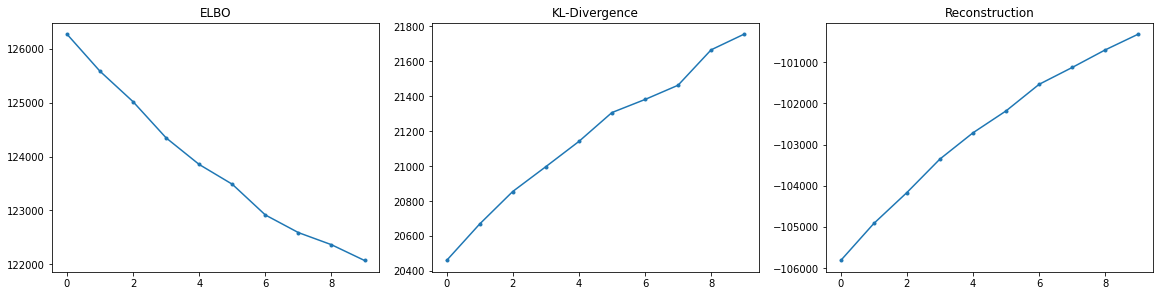

In [29]:
f, ax = plt.subplots(1, 3, figsize=(16,4), constrained_layout=True)
x = np.arange(epochs)
ax[0].plot(x, l_elbo, '.-')
ax[0].set_title('ELBO')
ax[1].plot(x, l_kld, '.-')
ax[1].set_title('KL-Divergence')
ax[2].plot(x, l_recon, '.-')
ax[2].set_title('Reconstruction')
plt.show()

In [ ]:
model.eval()
z_prior = Variable(torch.randn(16, 32)).to(device)

x_mu = model.sample(z_prior)

In [ ]:
f, axarr = plt.subplots(4, 4, figsize=(18, 12))

samples = x_mu.data.view(-1, 28, 28).cpu().numpy()

for i, ax in enumerate(axarr.flat):
    ax.imshow(samples[i])
    ax.axis("off")